In [14]:
import dgl
import numpy as np
import torch
import networkx as nx

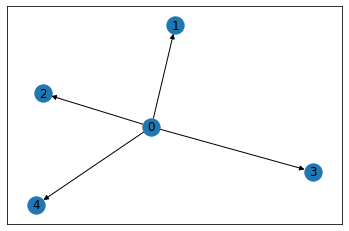

In [15]:
g = dgl.graph(([0,0,0,0], [1,2,3,4]), num_nodes=5)

gx = dgl.to_networkx(g)
nx.draw_networkx(gx)


In [42]:
g.ndata['value']  = torch.randn(5,3) #3d feature for node
g.edata['weight'] = torch.randn(4,4) #4d feature for edges

print(g.edata['weight']) # 4 edge -> 4 righe
print(g.ndata['value'])  # 5 nodi -> 5 righe


tensor([[ 0.9010,  0.3774, -3.0042, -0.7836],
        [-0.7770, -0.3493,  0.9463,  1.3448],
        [-0.2089,  0.6377, -0.2019,  0.3945],
        [-0.2402, -0.1977, -1.3756,  1.3288]])
tensor([[ 1.4676, -1.2603, -0.6252],
        [ 0.8028,  0.6238,  0.0762],
        [ 0.0375,  0.2553,  1.8162],
        [ 0.8194, -0.8165,  0.3995],
        [ 0.6286, -0.0279,  0.5836]])


DGL graph


In [34]:
G = dgl.DGLGraph()
G.add_nodes(3)
G.add_edges([1,2,3],1)
G

Graph(num_nodes=4, num_edges=3,
      ndata_schemes={}
      edata_schemes={})

In [66]:
graph = dgl.DGLGraph()

n = 10 # number of particles per jet
g.add_nodes(n)

src = []
dst = []
for i in range(n):
    for j in range(n):
        src.append(i)
        dst.append(j)

graph.add_edges(src, dst)


C:\Users\Pietro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\dgl\heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [67]:
print(graph.num_nodes())
print(graph.num_edges())

10
100


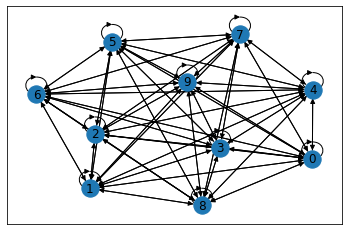

In [68]:
gx = dgl.to_networkx(graph)
nx.draw_networkx(gx)

In [72]:
node_feat = torch.randn(n,3)
graph.ndata['feat'] = node_feat
graph.ndata

{'feat': tensor([[ 0.2633, -1.0318,  0.7956],
        [ 0.1254,  1.2982,  0.6312],
        [ 1.0950, -1.0773, -0.7104],
        [-1.0701, -1.3677, -0.9968],
        [ 0.4319, -0.9860, -0.3057],
        [ 0.0058,  0.2219, -0.3444],
        [ 1.5192, -1.2264, -1.5820],
        [ 0.3733,  0.6305, -0.5645],
        [ 0.6671, -0.0095, -1.3574],
        [ 0.6137, -0.9788,  1.0351]])}

In [74]:
edge_feat = torch.randn(n**2, 3)
print(edge_feat.shape)

graph.edata['edge_feat'] = edge_feat
# graph.edata

torch.Size([100, 3])


In [ ]:
def build_graph(jet):
    """return a fully connected graph: 
        - n nodes -> n particles
        - n**2 edges -> each p is connected to all the others"""
    g = dgl.DGLGraph()
    n = len(jet)
    g.add_nodes(n)
    
    src = []; dst = []
    for i in range(n):
        for j in range(n):
            src.append(i)
            dst.append(j)

    graph.add_edges(src, dst)

    node_feat = jet # should be a tensor of shape [n, 5] where 5 are the features of each particle
    edge_feat = jet*jet # should be tensor of shape [n**2, 6 ]
    # the first n rows refer to the edges between the first particle and the other n ones

    graph.ndata['feat'] = node_feat
    graph.edata['edge_feat'] = edge_feat

    return g



## Decoder

In [8]:
from torch import nn
from dgl.nn import NNConv, EdgeConv

In [12]:
def MLP(efeat, ch=[256,128,64,32]):

    mlp = nn.Sequential(
        nn.Linear(len(efeat), ch[0]),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(ch[0],ch[1]),
        nn.Dropout(0.2),
        nn.ReLU(),
        
        nn.Linear(ch[1],ch[2]),
        nn.Dropout(0.2),
        nn.ReLU(),

        nn.Linear(ch[2], ch[3]),
        nn.Dropout(0.2),
        nn.Sigmoid()
    )
    
    return mlp(efeat)

In [14]:
class Encoder(nn.Module):
    
    def __init__(self, graph, latent_space_dim):
        super().__init__()
        
        self.conv = nn.Sequential(
            NNConv(
                in_feats = 7,  # number of node features
                out_fat = 128, # output number of node features
                edge_func = MLP),
            EdgeConv(128, 64),
            EdgeConv(64, 32),
            EdgeConv(32, latent_space_dim)
        )

    def forward(self, graph):
        x = self.conv(graph, graph.ndata, graph.edata)
        return x
    

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, graph, latent_space_dim):
        super().__init__()
        
        self.node_reconstruct = nn.Sequential(
            EdgeConv(latent_space_dim, 32),
            EdgeConv(32, 64),
            EdgeConv(64, 128),
            EdgeConv(128, 7))# output are the reconstructed node features

        self.edge_reconstruct = nn.Sequential(
            EdgeConv(latent_space_dim, 32),
            EdgeConv(32, 64),
            EdgeConv(64, 128),
            EdgeConv(128, 32),
            EdgeConv(32,16),
            EdgeConv(16,8)
        )

    def forward(self, graph):
        # node reconstruction
        n = self.node_reconstruct(graph, graph.ndata, graph.edata)
        
        # edges reconstruction
        e1 = self.edge_reconstruct(graph, graph.ndata, graph.edata)
        e2 = self.edge_reconstruct(graph, graph.ndata, graph.edata)
        e3 = self.edge_reconstruct(graph, graph.ndata, graph.edata)

        

        return n
    